In [1]:
!python -V

Python 3.6.9 :: Anaconda, Inc.


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import math
import tqdm
import imblearn

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] =False

In [3]:
base=r"D:\Game_lsh\weather"

# 训练集

## 标签读取

In [4]:
labels_path = os.path.join(base,"Train_label.csv")
labels_path

'D:\\Game_lsh\\weather\\Train_label.csv'

In [5]:
data = pd.read_csv(labels_path)
data.head()

FileName  type
0  00003a3f2faf4f6fb3aedf0188204487.jpg     6
1  0002c9161fb04a518198056ccd25c799.jpg     6
2  0002cf917ab24bfdb79330877dc664e4.jpg     8
3  0007163a879b41e3a92571e8b3b7dc0d.jpg     1
4  00117fc15033431395de297ee6c215c5.jpg     3

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6391 entries, 0 to 6390
Data columns (total 2 columns):
FileName    6391 non-null object
type        6391 non-null int64
dtypes: int64(1), object(1)
memory usage: 100.0+ KB


In [7]:
set([str(i).split(".")[1] for i in data["FileName"].values])

{'bmp', 'gif', 'jpeg', 'jpg', 'png'}

## 预处理

In [8]:
name_dict={i:j for i,j in zip(range(1,10),["雨凇","雾凇","雾霾","霜","露","结冰","降雨","降雪","冰雹"])}
name_dict

{1: '雨凇', 2: '雾凇', 3: '雾霾', 4: '霜', 5: '露', 6: '结冰', 7: '降雨', 8: '降雪', 9: '冰雹'}

In [9]:
data["label"]=data["type"].apply(lambda x:name_dict[x])
data.head()

FileName  type label
0  00003a3f2faf4f6fb3aedf0188204487.jpg     6    结冰
1  0002c9161fb04a518198056ccd25c799.jpg     6    结冰
2  0002cf917ab24bfdb79330877dc664e4.jpg     8    降雪
3  0007163a879b41e3a92571e8b3b7dc0d.jpg     1    雨凇
4  00117fc15033431395de297ee6c215c5.jpg     3    雾霾

In [10]:
pd.DataFrame(data.label.value_counts()).transpose()

雾凇   降雪    露   雾霾   冰雹   结冰    霜   降雨   雨凇
label  1296  896  841  815  606  594  499  471  373

## 删除不能读取的图片

In [11]:
img_size=[] # 统计图片大小 (W*H)^0.5 。
print(data.shape)
for i,d in tqdm.tqdm(list(data.iterrows())):
    img = cv2.imread(os.path.join(base,"Train",d.FileName))
    if img is None:
        print(i,d.FileName,d.type)
        print(None)
        data.drop(index=i,inplace=True)
    else:
        img_size.append(int(math.sqrt(img.shape[0]*img.shape[1])))
print(data.shape)

(6391, 3)


 19%|██████████▉                                               | 1207/6391 [00:15<00:57, 89.99it/s]

1207 2fa091e949864406a1f1c900e3020c9f.gif 8
None


 65%|█████████████████████████████████████▉                    | 4175/6391 [01:07<01:05, 33.75it/s]

4177 a49177093a954f0caf2804d3bc5ebdf3.jpg 6
None


 66%|██████████████████████████████████████▏                   | 4204/6391 [01:08<01:00, 36.13it/s]

4206 a5c619b4fcee403b9a2bc4eee435493a.jpg 7
None


 81%|██████████████████████████████████████████████▊           | 5165/6391 [01:28<00:22, 55.62it/s]

5170 ccf71cc987064f5aa5f8403ad9495a98.gif 7
None


100%|██████████████████████████████████████████████████████████| 6391/6391 [01:52<00:00, 56.75it/s]


(6387, 3)


## 图片大小分布

(324.88, 201.0)

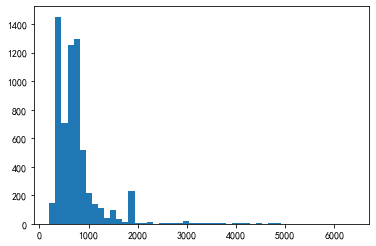

In [12]:
img_size = np.array(img_size)
img_size_res = plt.hist(img_size, bins=50)
img_size_res[1][np.argmax(img_size_res[0])],img_size_res[1][np.argmax(img_size_res[0])-1]

In [13]:
img_size_res

(array([1.450e+02, 1.451e+03, 7.060e+02, 1.253e+03, 1.292e+03, 5.150e+02,
        2.190e+02, 1.370e+02, 1.110e+02, 4.400e+01, 9.600e+01, 3.600e+01,
        1.000e+01, 2.310e+02, 9.000e+00, 5.000e+00, 1.200e+01, 2.000e+00,
        8.000e+00, 3.000e+00, 4.000e+00, 9.000e+00, 2.100e+01, 3.000e+00,
        3.000e+00, 3.000e+00, 9.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        9.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 7.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 201.  ,  324.88,  448.76,  572.64,  696.52,  820.4 ,  944.28,
        1068.16, 1192.04, 1315.92, 1439.8 , 1563.68, 1687.56, 1811.44,
        1935.32, 2059.2 , 2183.08, 2306.96, 2430.84, 2554.72, 2678.6 ,
        2802.48, 2926.36, 3050.24, 3174.12, 3298.  , 3421.88, 3545.76,
        3669.64, 3793.52, 3917.4 , 4041.28, 4165.16, 4289.04, 4412.92,
        4536.8 , 4660

(392.52, 376.56)

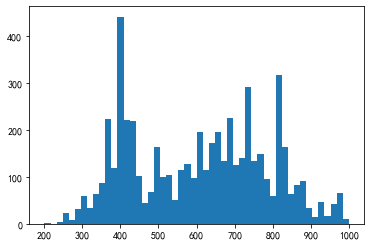

In [14]:
img_size_res = plt.hist(img_size[img_size<1000], bins=50)
img_size_res[1][np.argmax(img_size_res[0])],img_size_res[1][np.argmax(img_size_res[0])-1]

In [15]:
img_size_res

(array([  1.,   0.,   4.,  23.,   8.,  31.,  60.,  33.,  63.,  87., 223.,
        120., 442., 222., 219., 101.,  45.,  67., 163., 100., 105.,  50.,
        114., 127.,  98., 197., 114., 172., 196., 134., 226., 125., 140.,
        291., 134., 149.,  95.,  60., 317., 163.,  64.,  82.,  91.,  34.,
         14.,  47.,  16.,  42.,  65.,  11.]),
 array([201.  , 216.96, 232.92, 248.88, 264.84, 280.8 , 296.76, 312.72,
        328.68, 344.64, 360.6 , 376.56, 392.52, 408.48, 424.44, 440.4 ,
        456.36, 472.32, 488.28, 504.24, 520.2 , 536.16, 552.12, 568.08,
        584.04, 600.  , 615.96, 631.92, 647.88, 663.84, 679.8 , 695.76,
        711.72, 727.68, 743.64, 759.6 , 775.56, 791.52, 807.48, 823.44,
        839.4 , 855.36, 871.32, 887.28, 903.24, 919.2 , 935.16, 951.12,
        967.08, 983.04, 999.  ]),
 <a list of 50 Patch objects>)

## 分布占比

In [16]:
pd.DataFrame(data.label.value_counts()).transpose()

雾凇   降雪    露   雾霾   冰雹   结冰    霜   降雨   雨凇
label  1296  895  841  815  606  593  499  469  373

In [17]:
vc = Counter(data.type)
vc

Counter({6: 593,
         8: 895,
         1: 373,
         3: 815,
         7: 469,
         2: 1296,
         4: 499,
         5: 841,
         9: 606})

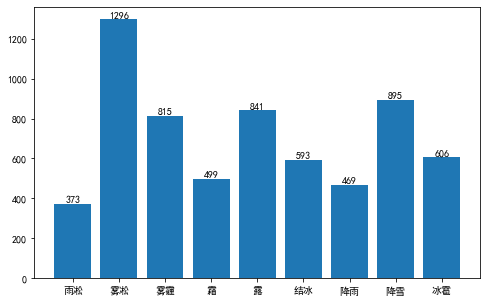

In [18]:
plt.figure(figsize =(8,5))
rects1 = plt.bar(x=range(1,10), height=[vc[i] for i in range(1,10)])
plt.xticks([i  for i in range(1,10)], [name_dict[i] for i in range(1,10)])
# 编辑文本
for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")

## 过采样

In [19]:
data.head()

FileName  type label
0  00003a3f2faf4f6fb3aedf0188204487.jpg     6    结冰
1  0002c9161fb04a518198056ccd25c799.jpg     6    结冰
2  0002cf917ab24bfdb79330877dc664e4.jpg     8    降雪
3  0007163a879b41e3a92571e8b3b7dc0d.jpg     1    雨凇
4  00117fc15033431395de297ee6c215c5.jpg     3    雾霾

In [20]:
pd.DataFrame(data.label.value_counts()).transpose()

雾凇   降雪    露   雾霾   冰雹   结冰    霜   降雨   雨凇
label  1296  895  841  815  606  593  499  469  373

In [21]:
ros = imblearn.over_sampling.RandomOverSampler()
x,y = ros.fit_sample(data.iloc[:,[0,2]],data.iloc[:,1])
res = pd.concat((pd.DataFrame(x,columns=["FileName","label"]),pd.DataFrame(y,columns=["type"])),axis=1)
res.head()

FileName label  type
0  00003a3f2faf4f6fb3aedf0188204487.jpg    结冰     6
1  0002c9161fb04a518198056ccd25c799.jpg    结冰     6
2  0002cf917ab24bfdb79330877dc664e4.jpg    降雪     8
3  0007163a879b41e3a92571e8b3b7dc0d.jpg    雨凇     1
4  00117fc15033431395de297ee6c215c5.jpg    雾霾     3

In [22]:
pd.DataFrame(res.label.value_counts()).transpose()

降雨     露    降雪     霜    冰雹    雨凇    雾凇    雾霾    结冰
label  1296  1296  1296  1296  1296  1296  1296  1296  1296

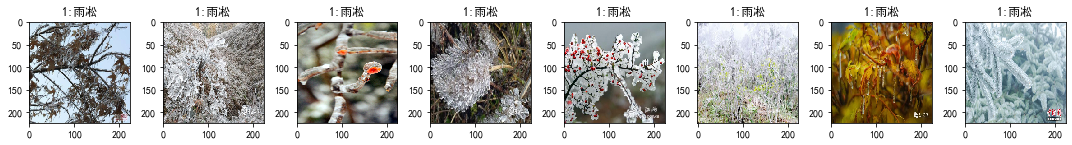

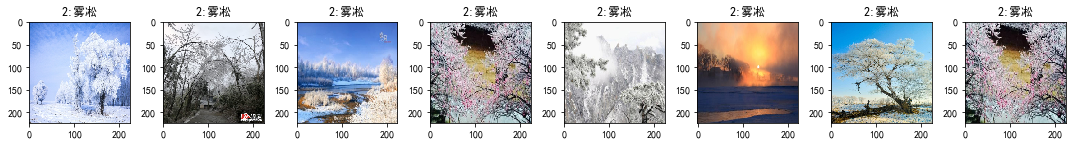

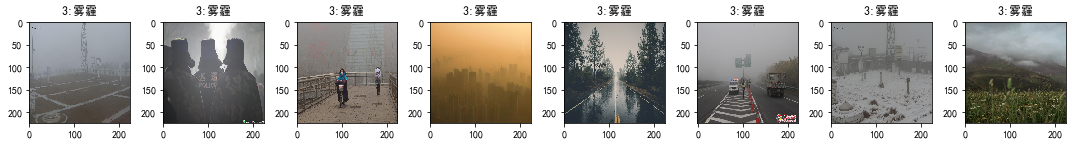

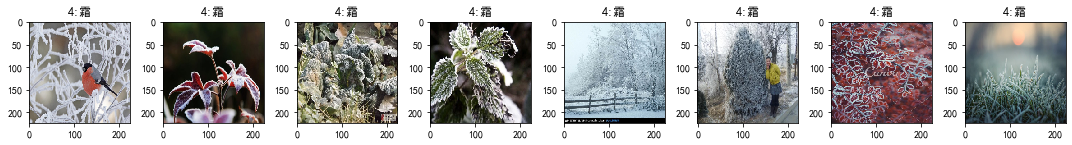

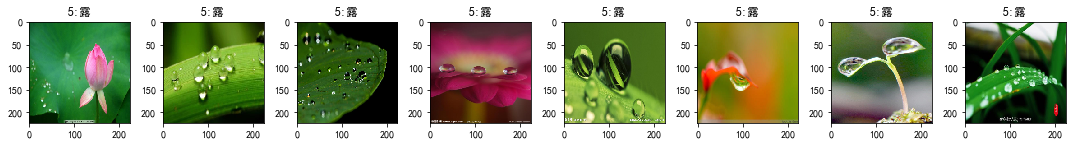

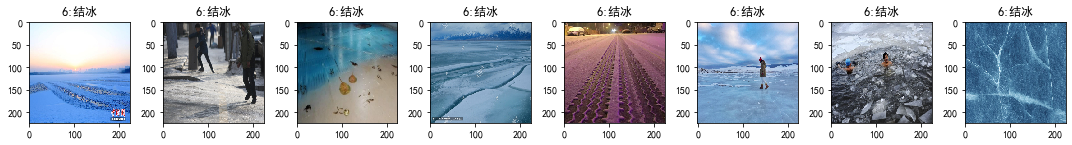

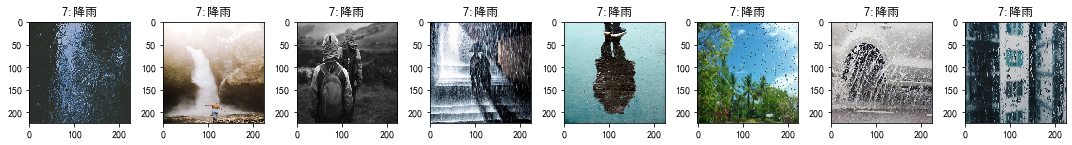

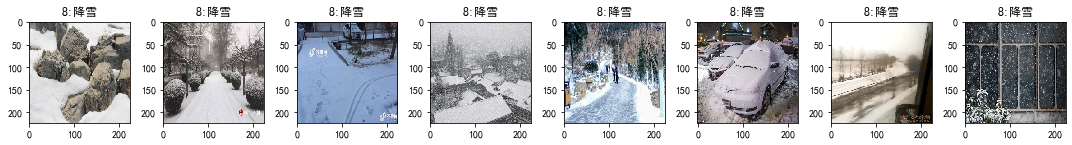

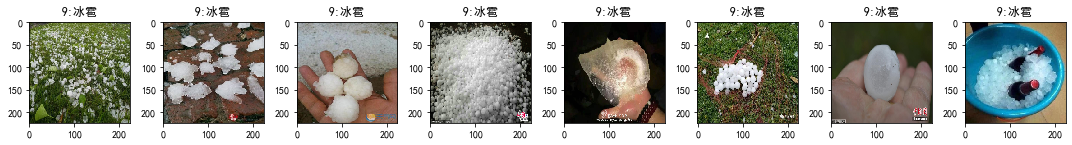

In [23]:
for i in range(1,10):
    fig = plt.figure(figsize =(15,6))
    data2show = data[data["type"]==i]
    for idx,ik in enumerate(data2show.iloc[np.random.randint(0,len(data2show),8,),:].values):
        ax = fig.add_subplot(1, 8, idx+1)
        img = cv2.imread(os.path.join(base,"Train",ik[0]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        ax.imshow(img)
        ax.set_title(f"{ik[1]}:{ik[2]}")
    plt.tight_layout()
    plt.show()

In [25]:
data.head(),res.head()

(                               FileName  type label
 0  00003a3f2faf4f6fb3aedf0188204487.jpg     6    结冰
 1  0002c9161fb04a518198056ccd25c799.jpg     6    结冰
 2  0002cf917ab24bfdb79330877dc664e4.jpg     8    降雪
 3  0007163a879b41e3a92571e8b3b7dc0d.jpg     1    雨凇
 4  00117fc15033431395de297ee6c215c5.jpg     3    雾霾,
                                FileName label  type
 0  00003a3f2faf4f6fb3aedf0188204487.jpg    结冰     6
 1  0002c9161fb04a518198056ccd25c799.jpg    结冰     6
 2  0002cf917ab24bfdb79330877dc664e4.jpg    降雪     8
 3  0007163a879b41e3a92571e8b3b7dc0d.jpg    雨凇     1
 4  00117fc15033431395de297ee6c215c5.jpg    雾霾     3)

In [26]:
# 保存
res.to_csv("data/eda_trainlabel_blance.csv",index=None)
data.to_csv("data/eda_trainlabel.csv",index=None)

# 测试集

In [27]:
test_path = os.path.join(base,"submit_example.csv")
test_path

'D:\\Game_lsh\\weather\\submit_example.csv'

In [28]:
test_data = pd.read_csv(test_path)
test_data.head()

FileName  type
0  000d96db4b884203a6728f74fa6c4df0.jpg     1
1  0012c73e64cb4260ba2852b61a302251.jpg     1
2  001667daa5af47c29f814999f39337f6.jpg     1
3  0026cb7f1d6144bc85f56f994f5ff9d4.jpg     1
4  006477d139c64d85a1e8cd496657268c.jpg     1

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260 entries, 0 to 4259
Data columns (total 2 columns):
FileName    4260 non-null object
type        4260 non-null int64
dtypes: int64(1), object(1)
memory usage: 66.7+ KB


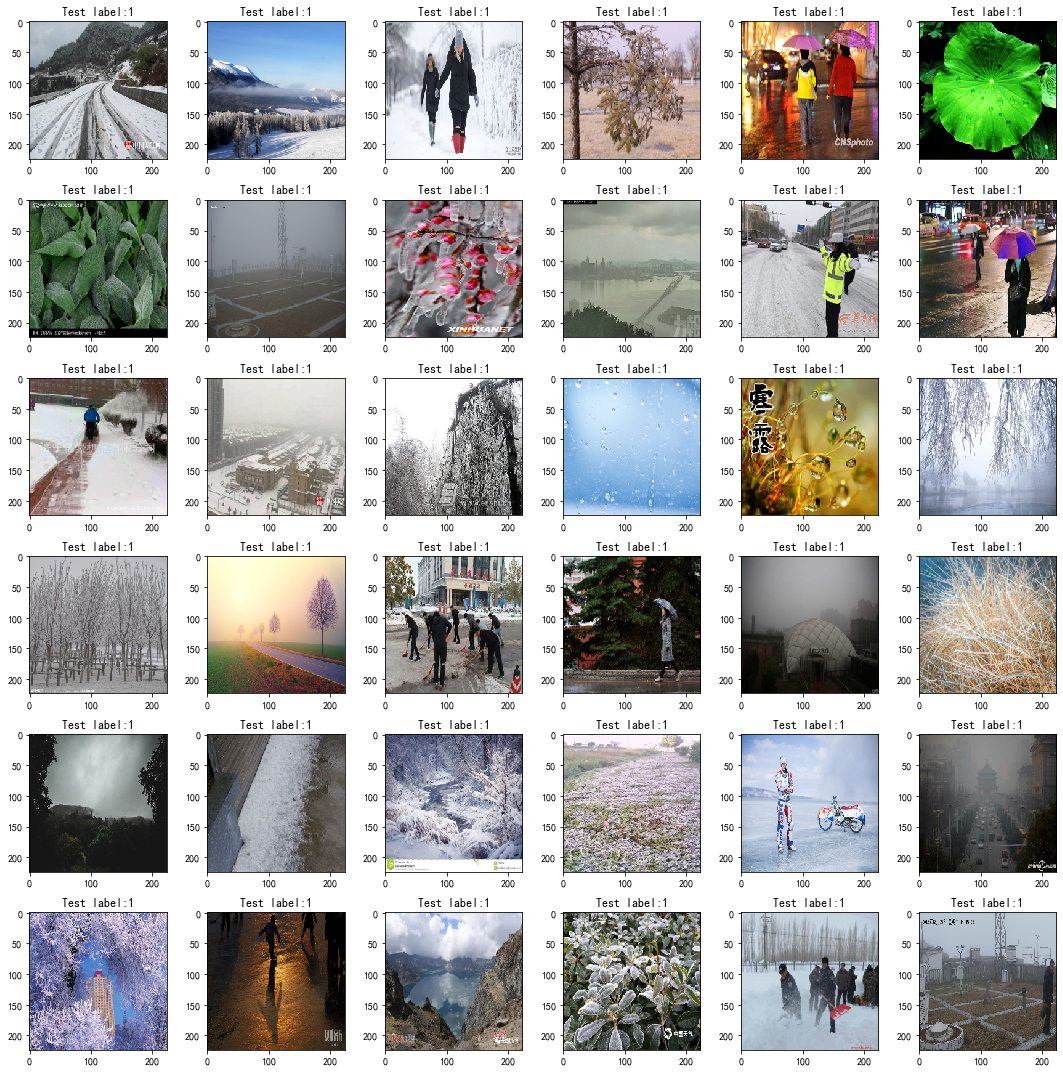

In [31]:
fig = plt.figure(figsize =(15,15))
for idx,ik in enumerate(test_data.loc[np.random.randint(0,len(test_data),36,)].values):
    ax = fig.add_subplot(6, 6, idx+1)
    img = cv2.imread(os.path.join(base,"Test",ik[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    ax.imshow(img)
    ax.set_title(f"Test label:{ik[1]}")
plt.tight_layout()
plt.show()